In [1]:
import sys
sys.path.append('/datasets/home/79/279/cs253wec/warp-ctc/lib')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import time
import copy
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim.lr_scheduler as lrs

import torchvision.utils as utils
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

from III5K import III5K

In [3]:
from warpctc_pytorch import CTCLoss

In [4]:
for f in [open('IIIT5K-Word_V3.0/train_Data.txt'),open('IIIT5K-Word_V3.0/test_Data.txt')]:
    words=[line.strip().split(',')[1] for line in f]
    vocab_set=[]
    max_len=-1
    for word in words:
        max_len=max(max_len,len(word))
        for c in word:
            vocab_set.append(c)
    vocab_set=set(vocab_set)
    print(f.name,':')
    print('maximum word length =',max_len)
    print('vocab size =',len(vocab_set),'\n')

IIIT5K-Word_V3.0/train_Data.txt :
maximum word length = 22
vocab size = 62 

IIIT5K-Word_V3.0/test_Data.txt :
maximum word length = 22
vocab size = 62 



In [5]:
vocab=[chr(ord('a')+i) for i in range(26)]+[chr(ord('A')+i) for i in range(26)]+[chr(ord('0')+i) for i in range(10)]+['-']
chrToindex={}
indexTochr={}
cnt=0
for c in vocab:
    chrToindex[c]=cnt
    indexTochr[cnt]=c
    cnt+=1
vocab_size=cnt # uppercase and lowercase English characters and digits(26+26+10=62)
batch_size=4
sequence_len=28
RNN_input_dim=7168
RNN_hidden_dim=64
RNN_layer=2
RNN_type='LSTM'
RNN_dropout=0

In [6]:
train_indices=range(100)

mytransform = T.Compose(
    [
        T.Scale((224,224)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
III5K_train = III5K("IIIT5K-Word_V3.0", mytransform, train=True)
loader_train = DataLoader(dataset = III5K_train,batch_size = batch_size, num_workers=2, 
                          sampler=SubsetRandomSampler(train_indices))

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


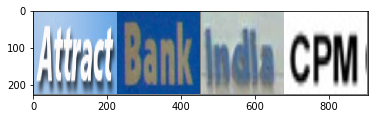

Attract Bank India CPM


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(loader_train)
images, labels = dataiter.next()

# print(images)
# print(labels)

imshow(utils.make_grid(images))
print(' '.join('%s' % labels[j] for j in range(4)))

In [8]:
print('CUDA available :',torch.cuda.is_available())
cpu_dtype = torch.FloatTensor # the CPU datatype
gpu_dtype = torch.cuda.FloatTensor # the GPU datatype

dtype=gpu_dtype
print(dtype)

# From torchvision/vgg.py
def reset(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
#             nn.init.xavier_normal(m.weight, gain=1)
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
#             nn.init.xavier_normal(m.weight, gain=1)
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()
            
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

CUDA available : True
<class 'torch.cuda.FloatTensor'>


In [9]:
class CNN_block(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(CNN_block, self).__init__()
        self.conv_1=nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.conv_2=nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.conv_3=nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.batchnorm=nn.BatchNorm2d(num_features=out_channel)
        self.relu=nn.ReLU(True)
        self.maxpool=nn.MaxPool2d(kernel_size=2,stride=2)
        
    def forward(self, x):
        x=self.relu(self.batchnorm(self.conv_1(x)))
        x=self.relu(self.batchnorm(self.conv_2(x)))
        x=self.relu(self.batchnorm(self.conv_3(x)))
        x=self.maxpool(x)
        return x
    
class ToRNN(nn.Module):
    def forward(self, x):
        x=x.permute(3,0,1,2)
        W,N,C,H= x.size()
        x.contiguous()
        return x.view(W,N,-1)
    
class BiDireRNN(nn.Module):
    def __init__(self):
        super(BiDireRNN, self).__init__()
        self.hidden_dim = RNN_hidden_dim
        self.num_layers=RNN_layer
        self.sql=sequence_len
        self.bsize=batch_size
        self.dropout=RNN_dropout
        self.rnn_type=RNN_type
        self.rnn = self.rnn_layer()
        self.hidden=None
        self.init_hidden()
        
    def rnn_layer(self):
        if self.rnn_type=='RNN':
            return nn.RNN(RNN_input_dim, self.hidden_dim, self.num_layers, dropout=self.dropout, bidirectional=True)
        elif self.rnn_type=='LSTM':
            return nn.LSTM(RNN_input_dim, self.hidden_dim, self.num_layers, dropout=self.dropout, bidirectional=True)
        elif self.rnn_type=='GRU':
            return nn.GRU(RNN_input_dim, self.hidden_dim, self.num_layers, dropout=self.dropout, bidirectional=True)
        else:
            raise AssertionError('unknown RNN type:',self.rnn_type)
    
    def init_hidden(self):
        if self.rnn_type=='LSTM':
            self.hidden=(Variable(torch.zeros(self.num_layers*2, self.bsize, self.hidden_dim).type(dtype)),
                    Variable(torch.zeros(self.num_layers*2, self.bsize, self.hidden_dim).type(dtype)))
        else:
            self.hidden=Variable(torch.zeros(self.num_layers*2, self.bsize, self.hidden_dim).type(dtype))
        
    
    def forward(self, x):
        rnn_out, self.hidden = self.rnn(x, self.hidden)
        return rnn_out
        

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.feature_extractor=nn.Sequential(*([CNN_block(3,64),CNN_block(64,128),CNN_block(128,256)]))
        self.toRNN=ToRNN()
        self.RNN=BiDireRNN()
        self.toTraget=nn.Linear(RNN_hidden_dim*2, vocab_size)

    def forward(self, x):
        feature=self.feature_extractor(x)
        RNN_input=self.toRNN(feature)
        RNN_out=self.RNN(RNN_input)
        tag_scores = self.toTraget(RNN_out)
        return tag_scores

In [10]:
my_model=Model().type(dtype)
print(my_model)

Model(
  (feature_extractor): Sequential(
    (0): CNN_block(
      (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    )
    (1): CNN_block(
      (conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    )
    (2): CNN_bl

In [11]:
_=my_model.apply(reset)
my_model.RNN.init_hidden()

In [12]:
x_var = Variable(images.type(dtype))
out=my_model(x_var)
print(out.size())

torch.Size([28, 4, 63])


In [13]:
out_size=Variable(torch.IntTensor([sequence_len] * batch_size))
y_size=Variable(torch.IntTensor([len(l) for l in labels]))
conc_label=''.join(labels)
y=[chrToindex[c] for c in conc_label]
y_var=Variable(torch.IntTensor(y))
print(y_var)
print(out_size)
print(y_size)
ctcloss=CTCLoss()
loss=ctcloss(out,y_var,out_size,y_size)
print(loss.data[0])

Variable containing:
 26
 19
 19
 17
  0
  2
 19
 27
  0
 13
 10
 34
 13
  3
  8
  0
 28
 41
 38
[torch.IntTensor of size 19]

Variable containing:
 28
 28
 28
 28
[torch.IntTensor of size 4]

Variable containing:
 7
 4
 5
 3
[torch.IntTensor of size 4]

396.3858642578125


(4, 256, 28, 28)


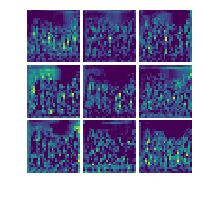

In [14]:
x_var = Variable(images.type(dtype))
out=my_model.feature_extractor(x_var)
feature_map=out.cpu().data.numpy()
print(feature_map.shape)
sample_index=np.random.choice(256,9)
plt.figure(figsize = (3,3))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(9):
    plt.subplot(gs1[i])
    feature_submap=feature_map[0,sample_index[i],:,:]
    plt.imshow(feature_submap)
    plt.axis('off')
plt.show()

In [15]:
# print(out.size())
# out=out.permute(3,0,1,2)
# print(out.size())

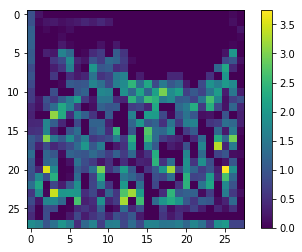

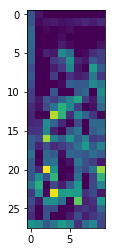

In [16]:
feature_submap=out[0,0,...].cpu().data.numpy()
plt.imshow(feature_submap)
plt.colorbar()
plt.show()

feature_submap=out[0,0,:,0:10].cpu().data.numpy()
plt.imshow(feature_submap)
plt.show()